# Kaggle IEEE-CIS-FraudDetection Competition

* Data: [https://www.kaggle.com/c/ieee-fraud-detection/data](https://www.kaggle.com/c/ieee-fraud-detection/data)
* EDA(Exploratory) part

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [43]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [45]:
trn_id = pd.read_csv('_input/train_identity.csv')
trn_tr = pd.read_csv('_input/train_transaction.csv')
tst_id = pd.read_csv('_input/test_identity.csv')
tst_tr = pd.read_csv('_input/test_transaction.csv')

print(trn_id.shape, trn_tr.shape)
print(tst_id.shape, tst_tr.shape)

((144233, 41), (590540, 394))
((141907, 41), (506691, 393))


In [46]:
trn_id = reduce_mem_usage(trn_id)
trn_tr = reduce_mem_usage(trn_tr)
tst_id = reduce_mem_usage(tst_id)
tst_tr = reduce_mem_usage(tst_tr)

Memory usage of dataframe is 45.00 MB --> 25.00 MB (Decreased by 44.0%)
Memory usage of dataframe is 1775.00 MB --> 542.00 MB (Decreased by 69.0%)
Memory usage of dataframe is 44.00 MB --> 25.00 MB (Decreased by 43.0%)
Memory usage of dataframe is 1519.00 MB --> 472.00 MB (Decreased by 68.0%)


In [50]:
def plotTrnHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([trn_tr_f0[col], trn_tr_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
        plt.show()

def plotTrnLogHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([np.log1p(trn_tr_f0[col]), np.log1p(trn_tr_f1[col])], bins=bins, density=True, color=['royalblue', 'orange'])
        plt.show()
        
def plotTrnCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = trn_tr_f0, trn_tr_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)
    plt.show()

In [51]:
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

trn_tr['Date'] = trn_tr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

trn_tr['_year'] = trn_tr['Date'].dt.year
trn_tr['_month'] = trn_tr['Date'].dt.month
trn_tr['_weekday'] = trn_tr['Date'].dt.dayofweek
trn_tr['_hour'] = trn_tr['Date'].dt.hour
trn_tr['_day'] = trn_tr['Date'].dt.day

trn_tr['_ymd'] = trn_tr['_year'].astype(str) + '-' + trn_tr['_month'].astype(str) + '-' + trn_tr['_day'].astype(str)
trn_tr['_ym'] = trn_tr['_year'].astype(str) + '-' + trn_tr['_month'].astype(str)

trn_tr['_weekday_hour'] = trn_tr['_weekday'].astype(str) + '_' + trn_tr['_hour'].astype(str)

In [52]:
trn_tr_f0 = trn_tr[trn_tr['isFraud'] == 0]
trn_tr_f1 = trn_tr[trn_tr['isFraud'] == 1]

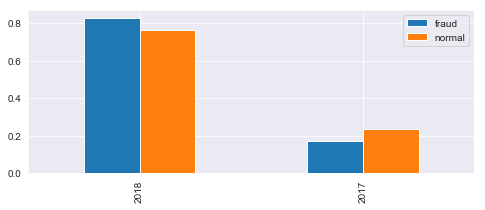

In [53]:
plotTrnCategoryRateBar('_year')

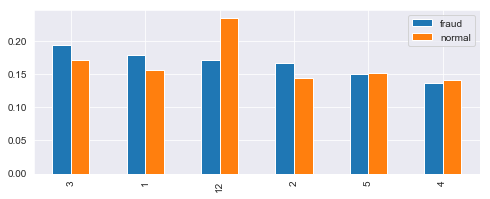

In [54]:
plotTrnCategoryRateBar('_month')

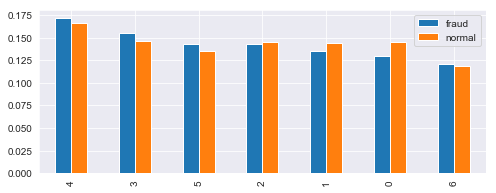

In [55]:
plotTrnCategoryRateBar('_weekday')

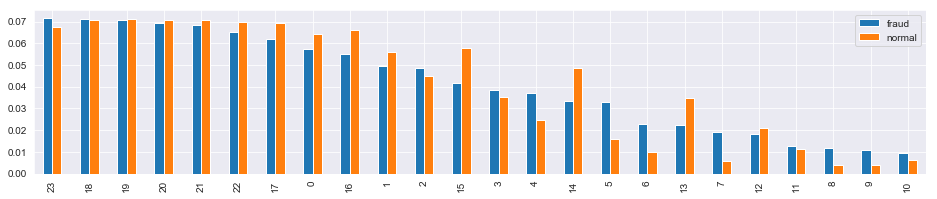

In [56]:
plotTrnCategoryRateBar('_hour', figsize=(16, 3))

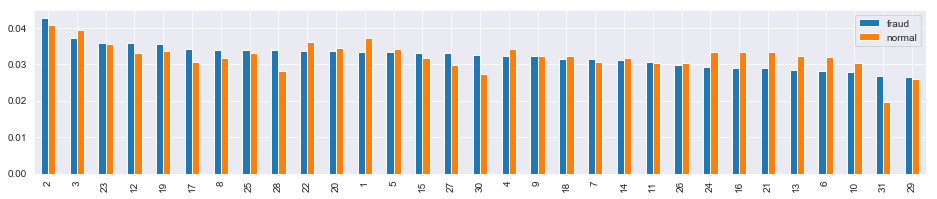

In [57]:
plotTrnCategoryRateBar('_day', figsize=(16,3))

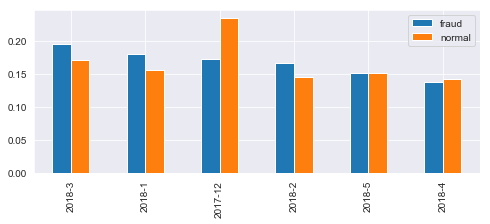

In [58]:
plotTrnCategoryRateBar('_ym')

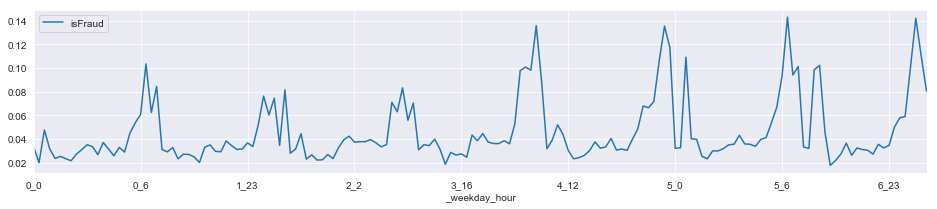

In [59]:
trn_tr.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))
plt.show()

In [61]:
card_cols = ['card%d' % i for i in range(1, 7)]
print(trn_tr[card_cols].head())

for c in card_cols:
    print('%s has %d unique values.' % (c, trn_tr[c].nunique()))

print()

   card1   card2   card3       card4   card5   card6
0  13926     nan 150.000    discover 142.000  credit
1   2755 404.000 150.000  mastercard 102.000  credit
2   4663 490.000 150.000        visa 166.000   debit
3  18132 567.000 150.000  mastercard 117.000   debit
4   4497 514.000 150.000  mastercard 102.000  credit
card1 has 13553 unique values.
card2 has 500 unique values.
card3 has 114 unique values.
card4 has 4 unique values.
card5 has 119 unique values.
card6 has 4 unique values.


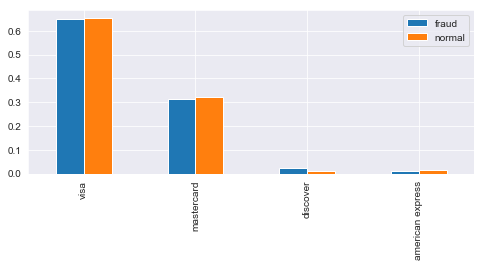

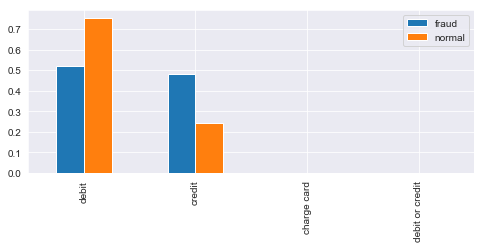

In [62]:
for c in ['card4', 'card6']:
    plotTrnCategoryRateBar(c)

In [63]:
trn_tr['_card1__card2'] = trn_tr['card1'].astype(str) + '__' + trn_tr['card2'].astype(str)
trn_tr['_card_n'] = trn_tr['card1'].astype(str) + '__' + trn_tr['card2'].astype(str) + '__' + trn_tr['card3'].astype(str) + '__' + trn_tr['card5'].astype(str)

In [65]:
cols = ['_card1__card2', '_card_n']

freq_cols = []
for c in cols:
    vc = trn_tr[c].value_counts(dropna=False)
    freq_c = '_freq_{}'.format(c)
    trn_tr[freq_c] = trn_tr[c].map(vc)
    freq_cols.append(freq_c)
    

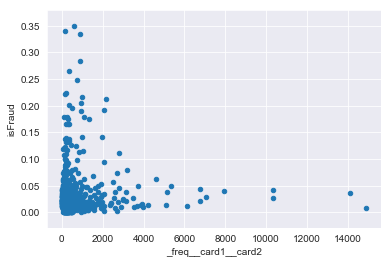

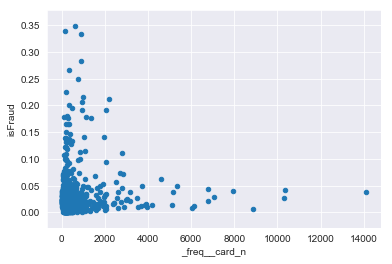

In [66]:
for fc in freq_cols:
    trn_tr.groupby(fc)['isFraud'].mean().to_frame().reset_index().plot.scatter(x=fc, y='isFraud')
    plt.show()

In [67]:
ccols = ['C%d' % i for i in range(1,15)]
dcols = ['D%d' % i for i in range(1,16)]
mcols = ['M%d' % i for i in range(1,10)]
vcols = ['V%d' % i for i in range(1,340)]

In [68]:
corr = trn_tr[['isFraud'] + vcols].corr()

In [74]:
corr['isFraud'].sort_values(ascending=False).head(20)

isFraud   1.000
V257      0.383
V246      0.367
V244      0.364
V242      0.361
V201      0.328
V200      0.319
V189      0.308
V188      0.304
V258      0.297
V45       0.282
V158      0.278
V156      0.276
V149      0.273
V228      0.269
V44       0.260
V86       0.252
V87       0.252
V170      0.250
V147      0.243
Name: isFraud, dtype: float64

In [80]:
corr['V257'].sort_values(ascending=False).head(20)

V257   1.000
V246   0.906
V199   0.872
V190   0.781
V258   0.779
V44    0.767
V244   0.758
V242   0.754
V200   0.748
V45    0.742
V201   0.733
V228   0.729
V86    0.661
V259   0.648
V186   0.638
V230   0.617
V176   0.617
V87    0.602
V170   0.600
V171   0.547
Name: V257, dtype: float64

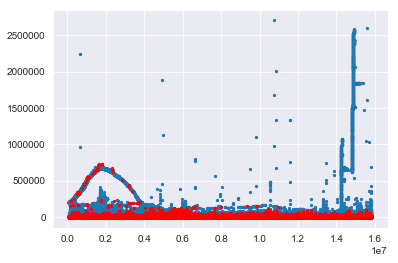

In [100]:
vsum0 = trn_tr_f0[vcols].sum(axis=1)
vsum1 = trn_tr_f1[vcols].sum(axis=1)

plt.scatter(trn_tr_f0['TransactionDT'], vsum0, s=5)
plt.scatter(trn_tr_f1['TransactionDT'], vsum1, s=5, c='r')

plt.show()

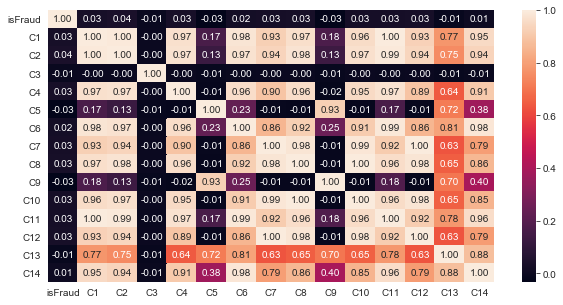

In [81]:
plt.figure(figsize=(10, 5))

corr = trn_tr[['isFraud'] + ccols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

plt.show()

D1 : 642 values in train, 643 values in test, 641 values in both 99.99980% repeated. 


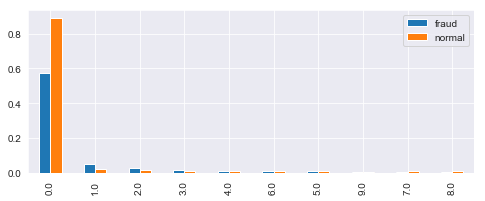

D2 : 642 values in train, 643 values in test, 641 values in both 99.99980% repeated. 


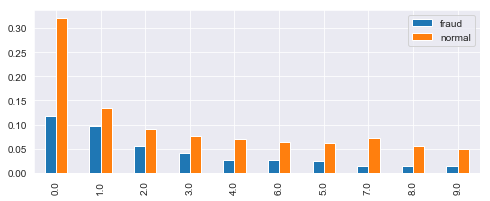

D3 : 650 values in train, 888 values in test, 648 values in both 99.79554% repeated. 


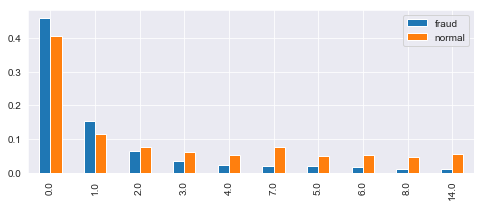

D4 : 809 values in train, 1057 values in test, 795 values in both 97.77044% repeated. 


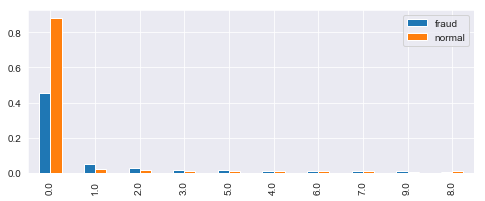

D5 : 689 values in train, 962 values in test, 688 values in both 99.66982% repeated. 


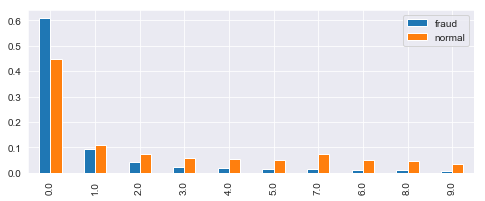

D6 : 830 values in train, 1073 values in test, 825 values in both 99.75942% repeated. 


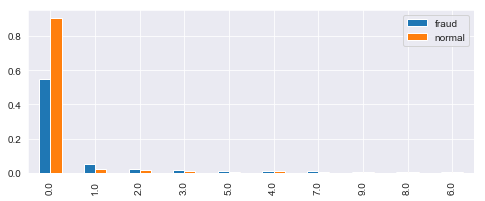

D7 : 598 values in train, 905 values in test, 596 values in both 99.76435% repeated. 


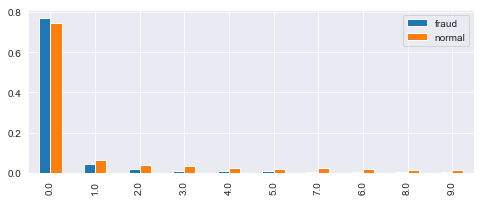

D8 : 5368 values in train, 5523 values in test, 5061 values in both 99.63429% repeated. 


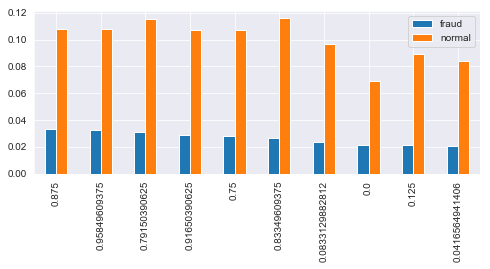

D9 : 25 values in train, 25 values in test, 24 values in both 100.00000% repeated. 


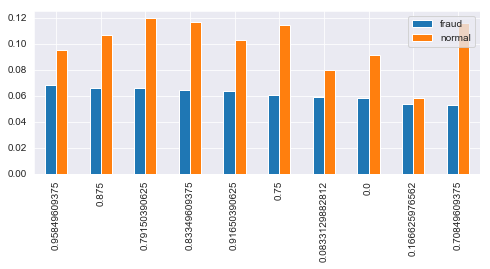

D10 : 819 values in train, 1076 values in test, 818 values in both 98.18450% repeated. 


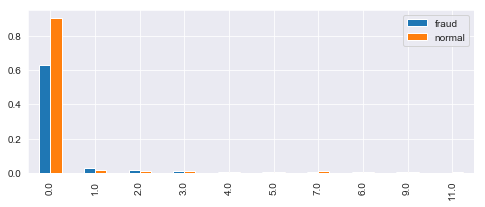

D11 : 677 values in train, 881 values in test, 669 values in both 94.44395% repeated. 


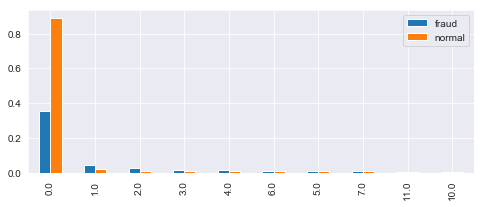

D12 : 636 values in train, 867 values in test, 633 values in both 99.55811% repeated. 


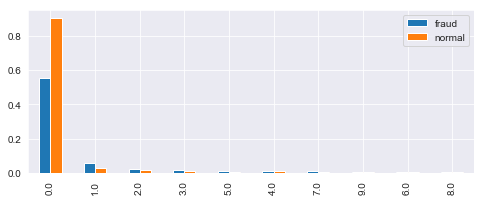

D13 : 578 values in train, 806 values in test, 555 values in both 99.87606% repeated. 


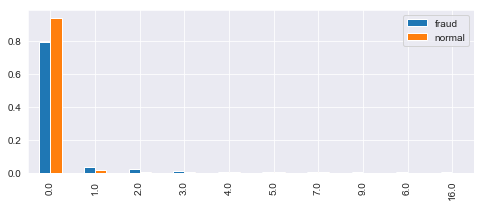

D14 : 803 values in train, 1032 values in test, 797 values in both 99.79988% repeated. 


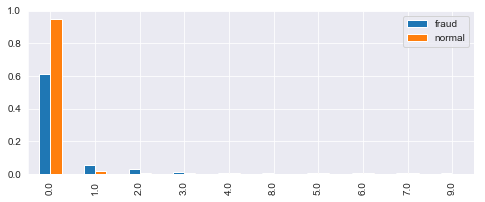

D15 : 860 values in train, 1079 values in test, 846 values in both 98.65520% repeated. 


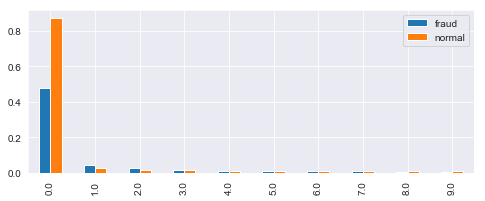

In [82]:
for c in dcols:
    values_trn = trn_tr[c].unique()
    values_tst = tst_tr[c].unique()
    values_both = list(set(values_trn).intersection(values_tst))
    n_trn = len(values_trn)
    n_tst = len(values_tst)
    n_both = len(values_both)
    repeatedness = tst_tr[c].isin(values_trn).mean()
    msg = '%s : %d values in train, %d values in test, %d values in both %.5f%% repeated. ' % (c, n_trn, n_tst, n_both, repeatedness*100)
    print(msg)
    plotTrnCategoryRateBar(c, 10)
    plt.show()

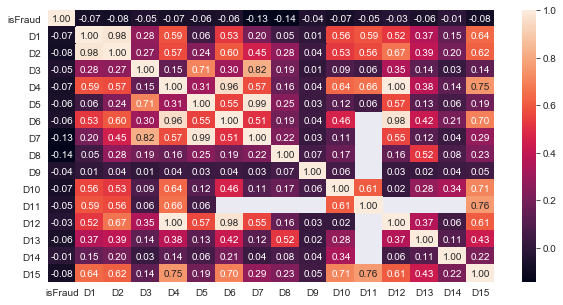

In [91]:
plt.figure(figsize=(10,5))

corr = trn_tr[['isFraud'] + dcols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

plt.show()

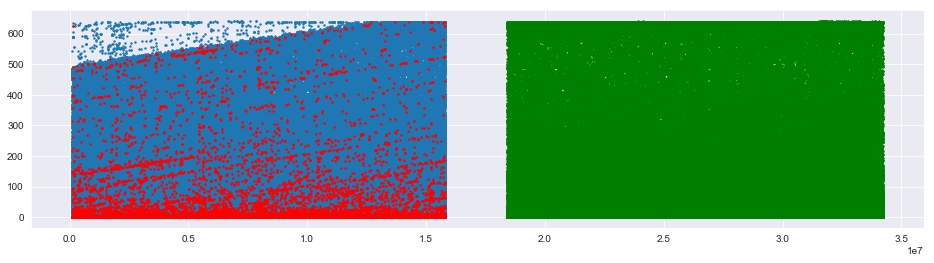

In [88]:
plt.figure(figsize=(16, 4))

plt.scatter(trn_tr_f0['TransactionDT'], trn_tr_f0['D1'], s=2)
plt.scatter(trn_tr_f1['TransactionDT'], trn_tr_f1['D1'], s=2, c='r')
plt.scatter(test_trn['TransactionDT'], test_trn['D1'], s=2, c='g')

plt.show()

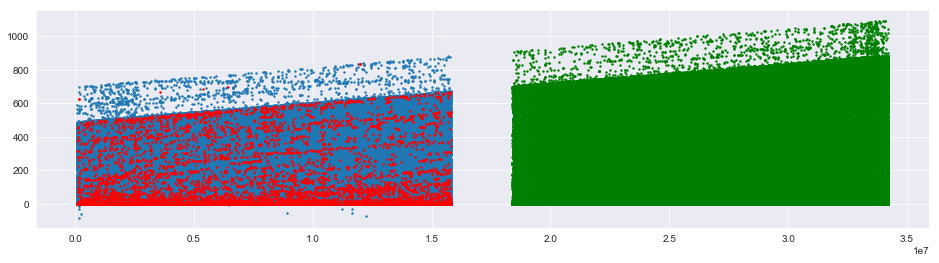

In [86]:
plt.figure(figsize=(16,4))

# ref. https://www.kaggle.com/kyakovlev/ieee-columns-scaling
plt.scatter(trn_tr_f0['TransactionDT'], trn_tr_f0['D15'], s=2)
plt.scatter(trn_tr_f1['TransactionDT'], trn_tr_f1['D15'], s=2, c='r')
plt.scatter(tst_tr['TransactionDT'], tst_tr['D15'], s=2, c='g')

plt.show()

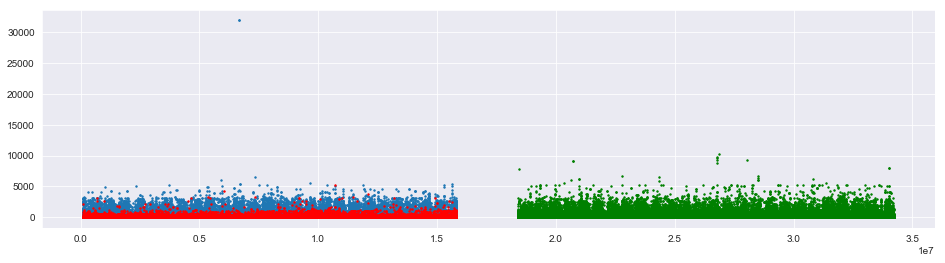

In [90]:
plt.figure(figsize=(16,4))

plt.scatter(trn_tr_f0['TransactionDT'], trn_tr_f0['TransactionAmt'], s=2)
plt.scatter(trn_tr_f1['TransactionDT'], trn_tr_f1['TransactionAmt'], s=2, c='r')
plt.scatter(tst_tr['TransactionDT'], tst_tr['TransactionAmt'], s=2, c='g')

plt.show()

In [99]:
sta = trn_tr['TransactionAmt'].astype('float64').describe().T
sta0 = trn_tr_f0['TransactionAmt'].astype('float64').describe().T
sta1 = trn_tr_f1['TransactionAmt'].astype('float64').describe().T

stats = pd.concat([sta, sta0, sta1], axis=1)
stats.columns = ['Train', 'Train Normal', 'Train Fraud']

stats

,Train,Train Normal,Train Fraud
count,"590,540.000","569,877.000","20,663.000"
mean,135.027,134.512,149.244
std,239.157,239.390,232.209
min,0.251,0.251,0.292
25%,43.312,43.969,35.031
50%,68.750,68.500,75.000
75%,125.000,120.000,161.000
max,"31,936.000","31,936.000","5,192.000"
